In [1]:
# Load the pickled data
import pickle

file_location = 'D:\\5005-Data\\tweet_combined_with_sentiment.pkl'

with open(file_location, 'rb') as f:
    tweets_dict = pickle.load(f)

len(tweets_dict)

1387322

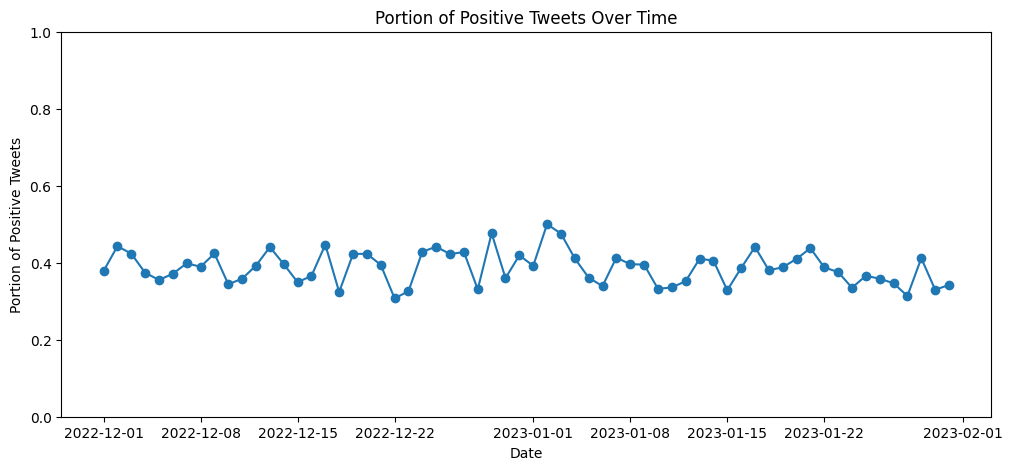

In [2]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# def safe_get(obj, *keys):
#     for key in keys:
#         if isinstance(obj, dict) and key in obj:
#             obj = obj[key]
#         else:
#             return False
#     return obj

# Define the date range for which we want to plot the graph
start_date = datetime.strptime('2022-12-01', '%Y-%m-%d')
end_date = datetime.strptime('2023-01-31', '%Y-%m-%d')

# Initialize the lists to store the count of positive and negative tweets for each date
positive_counts = []
negative_counts = []
dates = []

# Iterate over the date range and count the positive and negative tweets for each date
current_date = start_date
while current_date <= end_date:
    positive_count = 0
    negative_count = 0
    for tweet in tweets_dict.values():
        if not tweet.user.verified:
            continue
        tweet_datetime = tweet.date
        if tweet_datetime.date() == current_date.date():
            if tweet.sentiment == 'POSITIVE':
                positive_count += 1
            else:
                negative_count += 1
    
    positive_counts.append(positive_count)
    negative_counts.append(negative_count)
    dates.append(current_date.date())
    current_date += timedelta(days=1)

# Calculate the portion of positive tweets for each date
portion_positive = [p / (p + n) for p, n in zip(positive_counts, negative_counts)]

# Plot the graph
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(dates, portion_positive, marker="o")
ax.set_title("Portion of Positive Tweets Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Portion of Positive Tweets")
ax.set_ylim(0, 1)
plt.show()


In [3]:
import json
d3_data = [{'x': i, 'y': p, 'date': d.strftime('%Y-%m-%d')} for i, d, p in zip(range(len(dates)), dates, portion_positive)]

# Save the dictionary to a JSON file
with open('plotData.json', 'w') as f:
    json.dump(d3_data, f)

In [20]:
from matplotlib import colors

def interpolate_hex_colors(color1, color2, t):
    # Ensure t is between 0 and 1
    t = max(0, min(t, 1))

    # Convert hex colors to RGB
    r1, g1, b1 = int(color1[1:3], 16), int(color1[3:5], 16), int(color1[5:7], 16)
    r2, g2, b2 = int(color2[1:3], 16), int(color2[3:5], 16), int(color2[5:7], 16)

    # Interpolate RGB values
    r = round(r1 + (r2 - r1) * t)
    g = round(g1 + (g2 - g1) * t)
    b = round(b1 + (b2 - b1) * t)

    # Convert interpolated RGB values to hex
    interpolated_color = "#{:02x}{:02x}{:02x}".format(r, g, b)

    return interpolated_color


def warm_color_func(word, font_size, *args, **kwargs):
    # Define the color scale
    color_scale = ["#FFA500", "#FF2500"]

    # Normalize the font size to a value between 0 and 1
    min_font_size = 10  # Adjust this value based on the min font size in your word cloud
    max_font_size = 100  # Adjust this value based on the max font size in your word cloud
    normalized_font_size = (font_size - min_font_size) / (max_font_size - min_font_size)

    # Interpolate the color based on the normalized font size
    return interpolate_hex_colors(color_scale[0], color_scale[1], normalized_font_size)


def cold_color_func(word, font_size, *args, **kwargs):
    # Define the color scale
    color_scale = ["#00F050", "#0000FF"]

    # Normalize the font size to a value between 0 and 1
    min_font_size = 10  # Adjust this value based on the min font size in your word cloud
    max_font_size = 100  # Adjust this value based on the max font size in your word cloud
    normalized_font_size = (font_size - min_font_size) / (max_font_size - min_font_size)

    # Interpolate the color based on the normalized font size
    return interpolate_hex_colors(color_scale[0], color_scale[1], normalized_font_size)

In [11]:
import re

def remove_urls_and_entities(text):
    """
    Removes URLs and HTML entities from a string using regular expressions.
    
    Args:
        text (str): The input string to remove URLs and HTML entities from.
        
    Returns:
        str: The input string with any URLs and HTML entities removed.
    """
    # Define regular expressions to match URLs and HTML entities
    url_pattern = re.compile(r'https?://(?:www\.\S+|(?!www)\S+)')
    entity_pattern = re.compile(r'&\w+;')
    
    # Use the sub() method to replace URLs and HTML entities with an empty string
    text_without_urls_and_entities = url_pattern.sub('', text)
    text_without_urls_and_entities = entity_pattern.sub('', text_without_urls_and_entities)
    
    return text_without_urls_and_entities


def remove_chatgpt(string):
    pattern = re.compile(r"(#|)ChatGPT", re.IGNORECASE)
    clean_string = re.sub(pattern, "", string)
    return clean_string


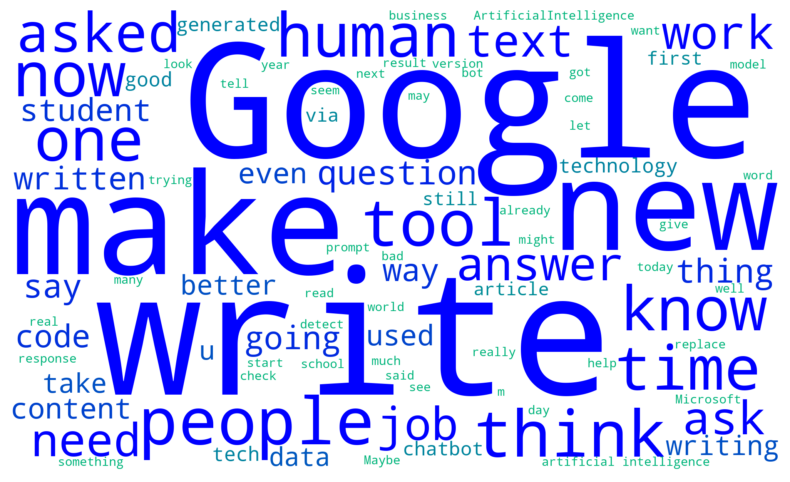

In [21]:
from wordcloud import WordCloud, STOPWORDS

def create_word_cloud(target, tweets_dict, sentiment=None):
    texts = []
    for tweet in tweets_dict.values():
        if sentiment is not None:
            if tweet.sentiment != sentiment:
                continue
        if tweet.date.date() == target.date():
            content = remove_urls_and_entities(tweet.rawContent)
            content = remove_chatgpt(content)
            texts.append(content)

    # Create a WordCloud object
    texts = ' '.join(texts)

    # Create a set of stopwords
    stopwords = set(STOPWORDS)

    # Add words to exclude
    stopwords.update(['AI', 'OpenAI', 'Open', 'use', 'using', 'will', 's'])

    if sentiment == 'POSITIVE':
        wordcloud = WordCloud(width=2000, height=1200, background_color='white', max_words=90, contour_width=3, prefer_horizontal=1, color_func=warm_color_func, stopwords=stopwords)
    else:
        wordcloud = WordCloud(width=2000, height=1200, background_color='white', max_words=90, contour_width=3, prefer_horizontal=1, color_func=cold_color_func, stopwords=stopwords)
    wordcloud.generate(texts)
    return wordcloud

def create_and_save_wc(date, sentiment=None):
    cloud = create_word_cloud(date, tweets_dict, sentiment)
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    if sentiment is not None:
        plt.savefig(f'wordcloud-vis/imgs/{date.date()}_{sentiment}.png')
    else:
        plt.savefig(f'wordcloud-vis/imgs/{date.date()}.png')


fig, ax = plt.subplots(figsize=(10, 6))

d = datetime.strptime('2022-12-01', '%Y-%m-%d')
while d <= datetime.strptime('2023-01-31', '%Y-%m-%d'):
    create_and_save_wc(d, 'POSITIVE')
    create_and_save_wc(d, 'NEGATIVE')
    d += timedelta(days=1)